# Correlation between Diversification rates and range sizes in Birds

In [12]:
import os 
import toytree
import toyplot
import pandas as pd
import numpy as np

In [62]:
#Create directories
if not os.path.exists('./databases'):
    os.makedirs('./databases')
if not os.path.exists('./trees'):
    os.makedirs('./trees')
if not os.path.exists('./stats'):
    os.makedirs('./stats')

## Download 10K bird trees and write to a single file

In [ ]:
# Bird tree supplement is on 
BIRD_ZIP = "https://data.vertlife.org/birdtree/Stage2/EricsonStage2_{}001_{}000.zip"

In [3]:
# the file path to write trees to
BIRD_TREES = "./trees/birds_EricsonStage2-10K-trees.nwk"

In [ ]:
# remove if file already exists
if os.path.exists(BIRD_TREES):
    os.remove(BIRD_TREES)

# iterate over the file chunks on vertlife
for i in range(10):

    # get the URL of the next file chunk
    path = BIRD_ZIP.format(i, i + 1)
    print(path)

    # download the zip file
    ! wget -q -P /tmp/ $path

    # get filename
    fname = path.rsplit("/")[-1]

    # decompress archive
    ! unzip -q -d /tmp /tmp/$fname

    # get newick from within weird inconsistent file paths in zipfiles
    spath = "/tmp/mnt/data/projects/birdphylo/Tree_sets/Stage2_full_data/CombinedTrees/"
    if not i:
        spath = os.path.join(spath, "AllBirdsEricson{}.tre".format(i + 1))
    else:
        spath = os.path.join(spath, "BirdzillaEricson{}.tre".format(i + 1))

    # append these trees to the full tree file
    ! cat $spath >> $BIRD_TREES

    # cleanup large temporary files
    os.remove(f"/tmp/{fname}")
    os.remove(spath)

# print success
print('10K trees written to {}'.format(BIRD_TREES))

In [64]:
# load the first tree in the file
tree = toytree.tree(BIRD_TREES)
print(tree.ntips, "tips in the Jetz bird trees")

9993 tips in the Jetz bird trees


## Calculate bird diversification rates

In [ ]:
from toytree.PCM import calculate_tip_level_diversification

In [ ]:
divdf = calculate_tip_level_diversification(BIRD_TREES, njobs=20)
divdf.to_csv("./stats/bird_DR-stats.csv", sep="\t")

In [19]:
#load divdf from file
divdf = pd.read_csv("./stats/bird_DR-stats.csv", index_col=0, sep="\t")

In [20]:
divdf

,mean,median,std,2.5%,97.5%,min,max
Poospiza_cinerea,0.987245,0.925135,0.309956,0.419491,0.531995,0.383694,3.427481
Poospiza_melanoleuca,0.993881,0.932580,0.318630,0.419491,0.533167,0.383694,5.205515
Poospiza_alticola,1.514849,1.399297,0.641893,0.387594,0.540834,0.344916,6.858527
Poospiza_erythrophrys,1.514653,1.401727,0.640061,0.375095,0.496351,0.304734,7.061746
Hemispingus_trifasciatus,1.292187,1.144193,0.627038,0.341079,0.475128,0.288737,6.220680
...,...,...,...,...,...,...,...
Casuarius_bennetti,0.094156,0.092959,0.027305,0.035918,0.044725,0.033815,0.213160
Casuarius_casuarius,0.094052,0.092707,0.026947,0.036149,0.045374,0.035524,0.213160
Dromaius_novaehollandiae,0.065696,0.063712,0.015275,0.030495,0.038673,0.027144,0.150362
Rhea_pennata,0.035043,0.034351,0.006723,0.018704,0.022494,0.016001,0.076111


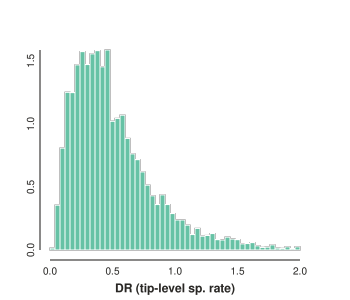

In [67]:
# plot distribution of DRs across tips
toyplot.bars(
    np.histogram(divdf['mean'], bins=50, range=(0, 2.0), density=True),
    xlabel="DR (tip-level sp. rate)",
    width=350,
    height=300,
);

## Load Bird geographic ranges (https://opentraits.org/datasets/avianhwi)

In [14]:
EXCELLINK = "https://raw.githubusercontent.com/catherinesheard/Global-HWI/master/Dataset%20HWI%202020-04-10.xlsx"

In [15]:
# download the file to /tmp
! wget -q -P ./databases/birds_Sheard-2020/ $EXCELLINK 

In [16]:
# load the mammal biological data (e.g., geo range)
cathdf = pd.read_excel("./databases/birds_Sheard-2020/Dataset HWI 2020-04-10.xlsx")

# drop rows that are missing range info
cathdf = cathdf.loc[~cathdf["Range Size"].isna()]
print(cathdf.shape[0], "taxa in Catherine's Global HWI database")

9949 taxa in Catherine's Global HWI database


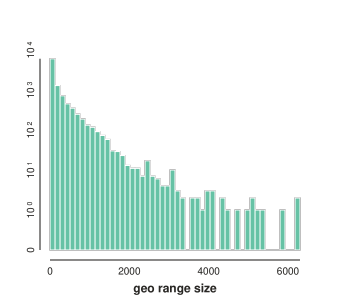

In [17]:
# distribution of geo ranges
toyplot.bars(
    np.histogram(cathdf['Range Size'], bins=50),
    width=350, 
    height=300,
    xlabel="geo range size",
    yscale='log',
);

## Combine datasets (divdf and cathdf)

In [21]:
# subselect species names, geo range, and migration columns
sppdata = cathdf.loc[:, ['Tree name', 'Range Size', "Migration-1", "Migration-2", "Migration-3"]]

# rename sppdata columns
sppdata.columns = ["species", "georange", "Migration-1", "Migration-2", "Migration-3"]

# make column to record DR stats
sppdata["divrate"] = 0

# get tips shared by tree and georange dataset
sppset = sorted(set(divdf.index.to_list()).intersection(set(sppdata.species)))

# reorder and subsample index to sppset names
sppdata = sppdata.set_index("species").loc[sppset].reset_index()

# fill divrate with estimated values
sppdata.loc[:, "divrate"] = divdf.loc[sppset, "mean"].values

In [22]:
# check if there is missing data
sppdata.isna().sum()

species          0
georange         0
Migration-1    136
Migration-2    131
Migration-3    146
divrate          0
dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sppdata['normgeo'] = StandardScaler().fit_transform(sppdata['georange'].values.reshape([-1, 1]))
sppdata['normdiv'] = StandardScaler().fit_transform(sppdata['divrate'].values.reshape([-1, 1]))
sppdata['scalegeo'] = MinMaxScaler().fit_transform(sppdata['georange'].values.reshape([-1, 1]))
sppdata['scalediv'] = MinMaxScaler().fit_transform(sppdata['divrate'].values.reshape([-1, 1]))

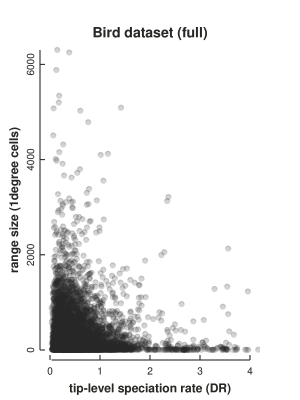

In [72]:
# Plot distribution range against diversification rate
toyplot.config.autoformat = "png"

c, a, m = toyplot.scatterplot(
    sppdata['divrate'],
    sppdata['georange'],
#     sppdata['divrate'],
#     np.log(sppdata['georange']),
    width=300, 
    height=400, 
    opacity=0.2,
    size=5,
    color="#262626",
    ylabel="range size (1degree cells)",
    xlabel="tip-level speciation rate (DR)",
    label=f"Bird dataset (full)"
);
a.x.ticks.show = True
a.y.ticks.show = True
a.x.domain.max = 4

In [ ]:
# write df to file
sppdata.set_index("species").to_csv("./birds-divgeo.csv")
sppdata

In [ ]:
# prune tree to sample in df
dtree = tree.drop_tips([i for i in tree.get_tip_labels() if i not in sppdata.species.tolist()])

# write pruned tree to file
dtree.write("./birds_prune_9947.tre")

## Test without species that are migrants

In [23]:
##Non migrants
#Check categories in each migrant clasificator
for i in range(1,4):
    print(f'Migration-{i}',sppdata[f'Migration-{i}'].unique())

Migration-1 ['Not a Migrant' 'Altitudinal Migrant' 'Full Migrant' nan 'Nomadic']
Migration-2 [ 1.  2.  3. nan]
Migration-3 ['resident' 'directional migratory' 'nomadic' 'dispersive migratory' nan
 'unknown']


In [24]:
#Create different dataframes base on migration clasifiers
no_migrants = [sppdata[sppdata['Migration-1']=='Not a Migrant'],
                sppdata[sppdata['Migration-2']==1], # Migration-2	Migration scores from Tobias et al. 2016 Frontiers in E&E. 1 = sedentary, 2 = partially migratory, 3 = fully migratory.
                sppdata[sppdata['Migration-3']=='resident']
]

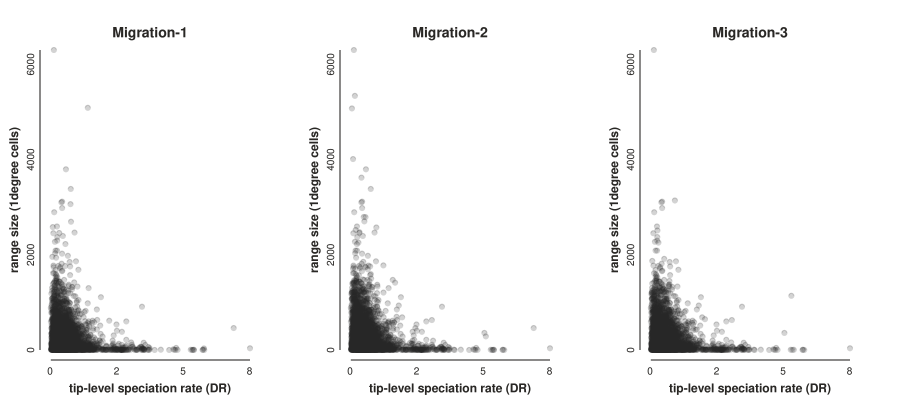

In [25]:
canvas = toyplot.Canvas(900, 400)


for idx, no_migrant in enumerate(no_migrants):
#     toyplot.config.autoformat = "png"
    
    axes = canvas.cartesian(
        grid=(1, 3, idx),
        ylabel="range size (1degree cells)",
        xlabel="tip-level speciation rate (DR)",
        label=f"Migration-{idx + 1}"
    )
    
    mark = axes.scatterplot(
        no_migrant['divrate'],
        no_migrant['georange'],
#         sppdata['divrate'],
#         np.log(sppdata['georange']),
        opacity=0.2,
        size=5,
        color="#262626"
    )

In [ ]:
canvas = toyplot.Canvas(900, 400)


for idx, no_migrant in enumerate(no_migrants):
#     toyplot.config.autoformat = "png"
    
    axes = canvas.cartesian(
        grid=(1, 3, idx),
        ylabel="log range size (1degree cells)",
        xlabel="tip-level speciation rate (DR)",
        label=f"Migration-{idx + 1} logged"
    )
    
    mark = axes.scatterplot(
        no_migrant['divrate'],
        np.log(no_migrant['georange']),
        opacity=0.2,
        size=5,
        color="#262626"
    )

In [ ]:
for idx, no_migrant in enumerate(no_migrants):
    # prune tree to sample in df
    dtree = tree.drop_tips([i for i in tree.get_tip_labels() if i not in no_migrant.species.tolist()])
    # write pruned tree to file
    dtree.write(f"./birdsnomigrants{idx+1}_prune.tre")
    # write df to file
    no_migrant.set_index("species").to_csv(f"./birdsnomigrants{idx+1}-divgeo.csv")

## Phylogenetic Linear Regression

In [2]:
%load_ext rpy2.ipython

In [75]:
%%R
#install.packages('phylolm')

library(phylolm)

set.seed(123456)
tre = read.tree("./birds_prune_9947.tre")
dat = read.csv("./birds-divgeo.csv", row.names=1)

phylolm_birds = phylolm(log(georange) ~ divrate, data=dat, phy=tre, model="lambda", boot=1000)
summary(phylolm_birds)


Call:
phylolm(formula = log(georange) ~ divrate, data = dat, phy = tre, 
    model = "lambda", boot = 1000)

   AIC logLik 
 37968 -18980 

Raw residuals:
    Min      1Q  Median      3Q     Max 
-4.5388 -1.5023 -0.1378  1.1347  4.4773 

Mean tip height: 123.4092
Parameter estimate(s) using ML:
lambda : 0.5620613
sigma2: 0.04072588 

Coefficients:
             Estimate    StdErr   t.value lowerbootCI upperbootCI   p.value    
(Intercept)  4.548303  0.713426  6.375298    3.071753      5.8783 1.907e-10 ***
divrate     -0.122945  0.039121 -3.142688   -0.197096     -0.0455  0.001679 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.0009921	Adjusted R-squared: 0.0008917 

Note: p-values and R-squared are conditional on lambda=0.5620613.

sigma2: 0.04072588
      bootstrap mean: 0.04055227 (on raw scale)
                      0.04052511 (on log scale, then back transformed)
      bootstrap 95% CI: (0.03762468,0.04339318)

lambda: 0.5620613
      bootstrap 

## Phyloml test for non migrants

In [3]:
%%R
#install.packages('phylolm')

library(phylolm)

set.seed(123456)
tre = read.tree("./birdsnomigrants1_prune.tre")
dat = read.csv("./birdsnomigrants1-divgeo.csv", row.names=1)

phylolm_birdsnonmigrants1 = phylolm(log(georange) ~ divrate, data=dat, phy=tre, model="lambda", boot=100)
summary(phylolm_birdsnonmigrants1)

R[write to console]: Loading required package: ape




Call:
phylolm(formula = log(georange) ~ divrate, data = dat, phy = tre, 
    model = "lambda", boot = 100)

   AIC logLik 
 28054 -14023 

Raw residuals:
    Min      1Q  Median      3Q     Max 
-4.3649 -1.4968 -0.2302  0.9483  4.5174 

Mean tip height: 123.4092
Parameter estimate(s) using ML:
lambda : 0.5790114
sigma2: 0.03911883 

Coefficients:
             Estimate    StdErr   t.value lowerbootCI upperbootCI   p.value    
(Intercept)  4.385052  0.710889  6.168408    3.077572      5.6610 7.258e-10 ***
divrate     -0.258733  0.052602 -4.918641   -0.339031     -0.1714 8.901e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.00323	Adjusted R-squared: 0.003096 

Note: p-values and R-squared are conditional on lambda=0.5790114.

sigma2: 0.03911883
      bootstrap mean: 0.0389821 (on raw scale)
                      0.03895761 (on log scale, then back transformed)
      bootstrap 95% CI: (0.03666855,0.04149452)

lambda: 0.5790114
      bootstrap mean:

In [4]:
%%R
#install.packages('phylolm')

library(phylolm)

set.seed(123456)
tre = read.tree("./birdsnomigrants2_prune.tre")
dat = read.csv("./birdsnomigrants2-divgeo.csv", row.names=1)

phyloml_birdsnonmigrants2 = phylolm(log(georange) ~ divrate, data=dat, phy=tre, model="lambda", boot=100)
summary(phyloml_birdsnonmigrants2)


Call:
phylolm(formula = log(georange) ~ divrate, data = dat, phy = tre, 
    model = "lambda", boot = 100)

   AIC logLik 
 29358 -14675 

Raw residuals:
    Min      1Q  Median      3Q     Max 
-4.4739 -1.5130 -0.2515  0.9134  4.2879 

Mean tip height: 123.4092
Parameter estimate(s) using ML:
lambda : 0.5626987
sigma2: 0.03813354 

Coefficients:
             Estimate    StdErr   t.value lowerbootCI upperbootCI   p.value    
(Intercept)  4.497740  0.692412  6.495752    3.222001      5.5635 8.768e-11 ***
divrate     -0.253247  0.052136 -4.857434   -0.342781     -0.1753 1.212e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.00301	Adjusted R-squared: 0.002883 

Note: p-values and R-squared are conditional on lambda=0.5626987.

sigma2: 0.03813354
      bootstrap mean: 0.03826221 (on raw scale)
                      0.03822998 (on log scale, then back transformed)
      bootstrap 95% CI: (0.03545284,0.0413672)

lambda: 0.5626987
      bootstrap mean:

In [5]:
%%R
#install.packages('phylolm')

library(phylolm)

set.seed(123456)
tre = read.tree("./birdsnomigrants3_prune.tre")
dat = read.csv("./birdsnomigrants3-divgeo.csv", row.names=1)

phylolm_birdsnonmigrants3 = phylolm(log(georange) ~ divrate, data=dat, phy=tre, model="lambda", boot=100)
summary(phylolm_birdsnonmigrants3)


Call:
phylolm(formula = log(georange) ~ divrate, data = dat, phy = tre, 
    model = "lambda", boot = 100)

   AIC logLik 
 28779 -14385 

Raw residuals:
    Min      1Q  Median      3Q     Max 
-4.3789 -1.5078 -0.2689  0.8948  4.3821 

Mean tip height: 123.4092
Parameter estimate(s) using ML:
lambda : 0.58622
sigma2: 0.0390363 

Coefficients:
             Estimate    StdErr   t.value lowerbootCI upperbootCI   p.value    
(Intercept)  4.401234  0.714158  6.162831    2.789118      5.9512 7.506e-10 ***
divrate     -0.237399  0.053768 -4.415234   -0.349905     -0.1091 1.023e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.002527	Adjusted R-squared: 0.002397 

Note: p-values and R-squared are conditional on lambda=0.58622.

sigma2: 0.0390363
      bootstrap mean: 0.03898662 (on raw scale)
                      0.03896214 (on log scale, then back transformed)
      bootstrap 95% CI: (0.03640688,0.04153565)

lambda: 0.58622
      bootstrap mean: 0.584

## Simple ml instead of phyloml

In [79]:
%%R

library(phylolm)

set.seed(123456)
tre = read.tree("./birds_prune_9947.tre")
dat = read.csv("./birds-divgeo.csv", row.names=1)

# dat = subset(dat, georange >= 1)

ml_birds = lm(log(georange) ~ divrate, data=dat) #Create a linear regression with two variables
summary(ml_birds)


Call:
lm(formula = log(georange) ~ divrate, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3766 -1.2709  0.1051  1.3624  5.5114 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.39911    0.02489 176.720   <2e-16 ***
divrate     -0.28974    0.03028  -9.568   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.784 on 9945 degrees of freedom
Multiple R-squared:  0.009121,	Adjusted R-squared:  0.009021 
F-statistic: 91.54 on 1 and 9945 DF,  p-value: < 2.2e-16



In [6]:
%%R

library(phylolm)

set.seed(123456)
tre = read.tree("./birdsnomigrants1_prune.tre")
dat = read.csv("./birdsnomigrants1-divgeo.csv", row.names=1)

# dat = subset(dat, georange >= 1)

lm_birdsnonmigrants1 = lm(log(georange) ~ divrate, data=dat) #Create a linear regression with two variables
summary(lm_birdsnonmigrants1)


Call:
lm(formula = log(georange) ~ divrate, data = dat)

Residuals:
   Min     1Q Median     3Q    Max 
-4.199 -1.172  0.084  1.268  5.813 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.24296    0.02915  145.54   <2e-16 ***
divrate     -0.56803    0.03823  -14.86   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.687 on 7467 degrees of freedom
Multiple R-squared:  0.02872,	Adjusted R-squared:  0.02859 
F-statistic: 220.8 on 1 and 7467 DF,  p-value: < 2.2e-16



In [7]:
%%R

library(phylolm)

set.seed(123456)
tre = read.tree("./birdsnomigrants2_prune.tre")
dat = read.csv("./birdsnomigrants2-divgeo.csv", row.names=1)

# dat = subset(dat, georange >= 1)

lm_birdsnonmigrants2 = lm(log(georange) ~ divrate, data=dat) #Create a linear regression with two variables
summary(lm_birdsnonmigrants2)


Call:
lm(formula = log(georange) ~ divrate, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.2882 -1.1810  0.0667  1.2533  5.7597 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.34242    0.02843  152.72   <2e-16 ***
divrate     -0.57469    0.03737  -15.38   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.687 on 7814 degrees of freedom
Multiple R-squared:  0.02938,	Adjusted R-squared:  0.02926 
F-statistic: 236.5 on 1 and 7814 DF,  p-value: < 2.2e-16



In [8]:
%%R

library(phylolm)

set.seed(123456)
tre = read.tree("./birdsnomigrants3_prune.tre")
dat = read.csv("./birdsnomigrants3-divgeo.csv", row.names=1)

# dat = subset(dat, georange >= 1)

lm_birdsnonmigrants3 = lm(log(georange) ~ divrate, data=dat) #Create a linear regression with two variables
summary(lm_birdsnonmigrants3)


Call:
lm(formula = log(georange) ~ divrate, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1765 -1.1529  0.0743  1.2487  5.7612 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.22891    0.02867  147.52   <2e-16 ***
divrate     -0.55577    0.03829  -14.51   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.667 on 7695 degrees of freedom
Multiple R-squared:  0.02664,	Adjusted R-squared:  0.02652 
F-statistic: 210.6 on 1 and 7695 DF,  p-value: < 2.2e-16



## plots in R

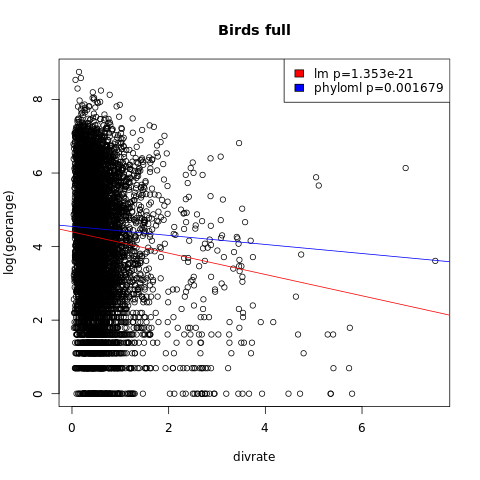

In [95]:
%%R
plot(log(georange)~divrate, data=dat, main="Birds full")
abline(ml_birds, col="red")
abline(phylolm_birds, col="blue")
legend("topright", c(paste("lm"," p=",formatC(summary(ml_birds)$coefficients[,4][2],4),sep=""),
                     paste("phyloml"," p=",formatC(summary(phylolm_birds)$coefficients[,6][2],4),sep="")), fill=c("red","blue"))

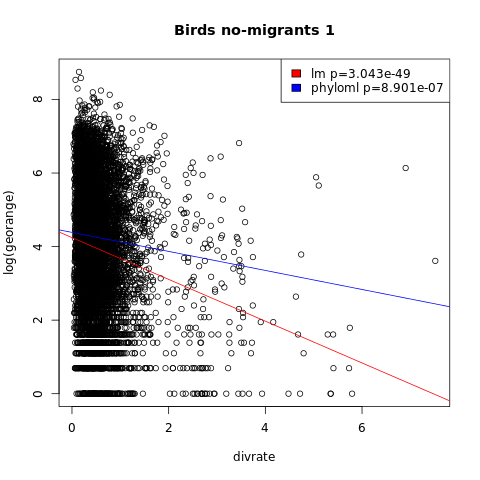

In [96]:
%%R
plot(log(georange)~divrate, data=dat, main="Birds no-migrants 1")
abline(lm_birdsnonmigrants1, col="red")
abline(phylolm_birdsnonmigrants1, col="blue")
legend("topright", c(paste("lm"," p=",formatC(summary(lm_birdsnonmigrants1)$coefficients[,4][2],4),sep=""),
                     paste("phyloml"," p=",formatC(summary(phylolm_birdsnonmigrants1)$coefficients[,6][2],4),sep="")), fill=c("red","blue"))

## Plot in toyplot

In [97]:
%%R -o phylolm -o lm
## Export variables from R cells to Python cells
phylolm = phylolm_birds
lm = ml_birds

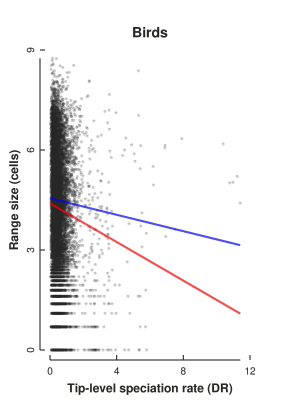

In [108]:
toyplot.config.autoformat = "png"

xmax = sppdata['divrate'].max()

c, a, m = toyplot.scatterplot(
#     sppdata['divrate'],
#     sppdata['georange'],
    sppdata['divrate'],
    np.log(sppdata['georange']),
    width=300, 
    height=400, 
    opacity=0.2,
    size=2,
    color="#262626",
    ylabel="Range size (cells)",
    xlabel="Tip-level speciation rate (DR)",
    label=f"Birds"
);
a.x.ticks.show = True
a.y.ticks.show = True
# a.y.domain.min = 0

a.plot(
    np.linspace(0, xmax),
    [lm[0][0] + lm[0][1] * i for i in np.linspace(0, xmax)],
    stroke_width=2,
    color="red",
    opacity=0.7
);

a.plot(
    np.linspace(0, xmax),
    [phylolm[0][0] + phylolm[0][1] * i for i in np.linspace(0, xmax)],
    stroke_width=2,
    color="blue",
    opacity=0.7
);

In [110]:
import toyplot.svg
toyplot.svg.render(c, "birds.svg")

### Plots in toytree for migrants

In [75]:
%%R -o phylolm -o lm
## Export variables from R cells to Python cells
phylolm = c(phylolm_birdsnonmigrants1[1], phyloml_birdsnonmigrants2[1], phylolm_birdsnonmigrants3[1])
lm = c(lm_birdsnonmigrants1[1], lm_birdsnonmigrants2[1], lm_birdsnonmigrants3[1])

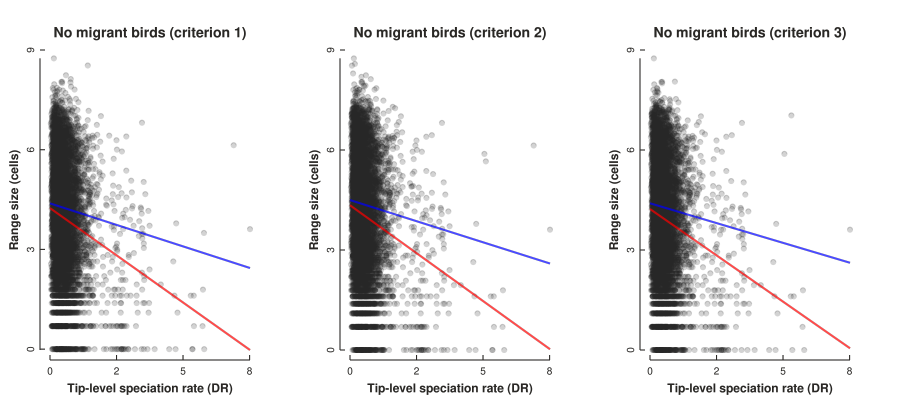

In [80]:
canvas = toyplot.Canvas(900, 400)


for idx, no_migrant in enumerate(no_migrants):
#     toyplot.config.autoformat = "png"
    xmax = no_migrant['divrate'].max()
    
    axes = canvas.cartesian(
        grid=(1, 3, idx),
        ylabel="Range size (cells)",
        xlabel="Tip-level speciation rate (DR)",
        label=f"No migrant birds (criterion {idx + 1})"
    )
    
    mark = axes.scatterplot(
        no_migrant['divrate'],
        np.log(no_migrant['georange']),
#         sppdata['divrate'],
#         np.log(sppdata['georange']),
        opacity=0.2,
        size=5,
        color="#262626"
    )
    
    axes.x.ticks.show = True
    axes.y.ticks.show = True
    # a.y.domain.min = 0

    axes.plot(
        np.linspace(0, xmax),
        [lm[idx][0] + lm[idx][1] * i for i in np.linspace(0, xmax)],
        stroke_width=2,
        color="red",
        opacity=0.7
    );

    axes.plot(
        np.linspace(0, xmax),
        [phylolm[idx][0] + phylolm[idx][1] * i for i in np.linspace(0, xmax)],
        stroke_width=2,
        color="blue",
        opacity=0.7
    );

In [81]:
import toyplot.svg
toyplot.svg.render(canvas, f"birds-no_migrants.svg")